# Cricket Object Detection - Project Notebook

This notebook demonstrates the complete pipeline for detecting cricket objects (bat, ball, stumps) in images using an 8x8 grid-based approach with hand-crafted features.

## Problem Statement
- Detect whether regions in a cricket image contain a bat, ball, stumps, or no object
- Each 800x600 image is divided into an 8x8 grid (64 cells)
- Use hand-crafted features only (no CNNs)

## Classes
- 0 → No object
- 1 → Ball
- 2 → Bat
- 3 → Stump

In [1]:
# Import required libraries

import sys
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Add source directory to path
sys.path.insert(0, 'src')

from utils import (
    CLASS_LABELS, TOTAL_CELLS, IMAGE_WIDTH, IMAGE_HEIGHT,
    GRID_ROWS, GRID_COLS, CELL_WIDTH, CELL_HEIGHT,
    get_grid_cell_bounds, create_csv_header, create_csv_row
)
from preprocess import preprocess_image, split_image_to_grid, image_to_numpy
from features import extract_grid_features, extract_cell_features
from annotate import create_annotation, save_annotations_batch, visualize_annotation
from train import train_model, prepare_training_data, save_trained_model
from predict import predict_image, generate_csv_output, load_trained_model

print("All modules imported successfully!")

All modules imported successfully!


## 1. Understanding the Grid System

Each 800x600 image is divided into an 8x8 grid:
- 64 cells total
- Each cell is 100x75 pixels
- Cells are numbered c01 to c64 (row-major order)

In [2]:
# Visualize the grid system
print(f"Image dimensions: {IMAGE_WIDTH}x{IMAGE_HEIGHT}")
print(f"Grid size: {GRID_ROWS}x{GRID_COLS} = {TOTAL_CELLS} cells")
print(f"Cell size: {CELL_WIDTH}x{CELL_HEIGHT} pixels")

# Show grid cell numbering
print("\nGrid Cell Numbering (c01 to c64):")
for row in range(GRID_ROWS):
    cells = [f"c{row*GRID_COLS+col+1:02d}" for col in range(GRID_COLS)]
    print(" | ".join(cells))

Image dimensions: 800x600
Grid size: 8x8 = 64 cells
Cell size: 100x75 pixels

Grid Cell Numbering (c01 to c64):
c01 | c02 | c03 | c04 | c05 | c06 | c07 | c08
c09 | c10 | c11 | c12 | c13 | c14 | c15 | c16
c17 | c18 | c19 | c20 | c21 | c22 | c23 | c24
c25 | c26 | c27 | c28 | c29 | c30 | c31 | c32
c33 | c34 | c35 | c36 | c37 | c38 | c39 | c40
c41 | c42 | c43 | c44 | c45 | c46 | c47 | c48
c49 | c50 | c51 | c52 | c53 | c54 | c55 | c56
c57 | c58 | c59 | c60 | c61 | c62 | c63 | c64


In [3]:
# Demonstrate cell bounds
print("Cell Bounds Examples:")
for cell_idx in [1, 8, 35, 64]:
    x1, y1, x2, y2 = get_grid_cell_bounds(cell_idx)
    print(f"  Cell c{cell_idx:02d}: x=[{x1}, {x2}), y=[{y1}, {y2})")

Cell Bounds Examples:
  Cell c01: x=[0, 100), y=[0, 75)
  Cell c08: x=[700, 800), y=[0, 75)
  Cell c35: x=[200, 300), y=[300, 375)
  Cell c64: x=[700, 800), y=[525, 600)


## 2. Image Preprocessing

Images must be:
- 4:3 aspect ratio
- 800x600 pixels
- Not upscaled (min original size 800x600)

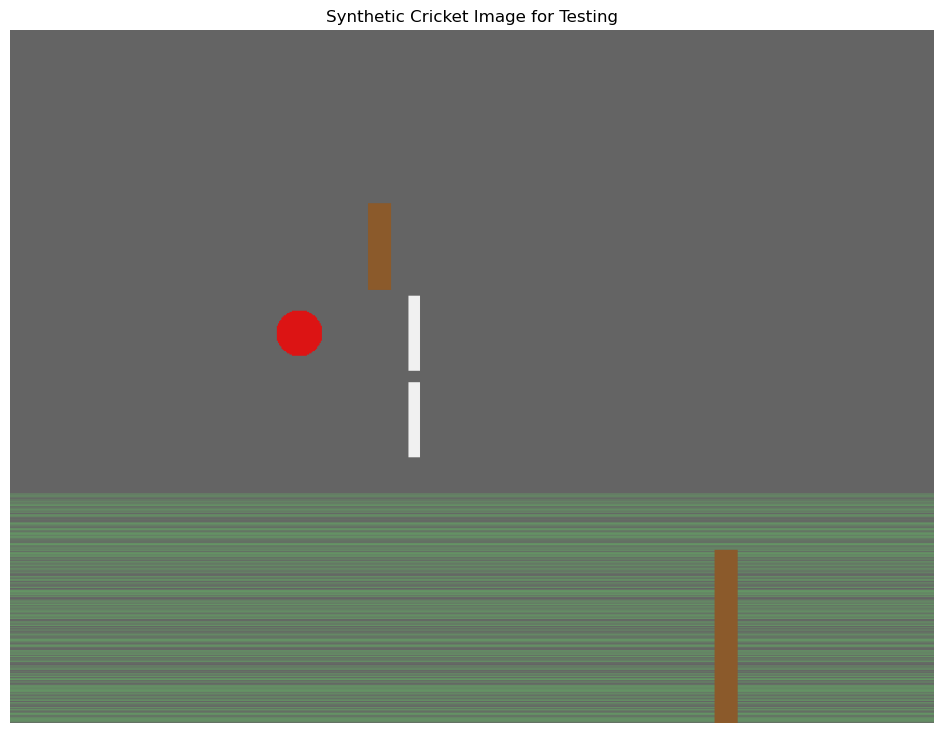

In [4]:
# Create a synthetic test image for demonstration
def create_synthetic_cricket_image():
    """Create a synthetic cricket image for testing."""
    img = np.ones((600, 800, 3), dtype=np.uint8) * 100  # Gray background
    
    # Add green grass-like texture
    for y in range(400, 600):
        intensity = 100 + np.random.randint(0, 50)
        img[y, :, 1] = intensity  # Green channel
    
    # Add red ball in cell 35 (row 4, col 3)
    cy, cx = 262, 250  # Center of cell 35
    for y in range(cy-20, cy+20):
        for x in range(cx-20, cx+20):
            if (y-cy)**2 + (x-cx)**2 < 20**2:
                img[y, x] = [220, 20, 20]  # Red
    
    # Add brown bat in cells 20, 55, 63 (diagonal)
    for cell_idx in [20, 55, 63]:
        x1, y1, x2, y2 = get_grid_cell_bounds(cell_idx)
        # Draw diagonal bat segment
        for i in range(75):
            if y1+i < 600 and x1+i < x2:
                img[y1+i, x1+10:x1+30] = [139, 90, 43]  # Brown
    
    # Add white stumps in cells 28, 36
    for cell_idx in [28, 36]:
        x1, y1, x2, y2 = get_grid_cell_bounds(cell_idx)
        # Draw vertical stumps
        img[y1+5:y2-5, x1+45:x1+55] = [240, 240, 240]  # White
    
    return img

# Create and display
synthetic_img = create_synthetic_cricket_image()
plt.figure(figsize=(12, 9))
plt.imshow(synthetic_img)
plt.title('Synthetic Cricket Image for Testing')
plt.axis('off')
plt.show()

## 3. Feature Extraction

We use hand-crafted features including:
- Color histograms (RGB and HSV)
- Histogram of Oriented Gradients (HOG)
- Edge features
- Shape features (Hu moments)
- Color moments
- Texture features

Split image into 64 cells
Each cell shape: (75, 100, 3)


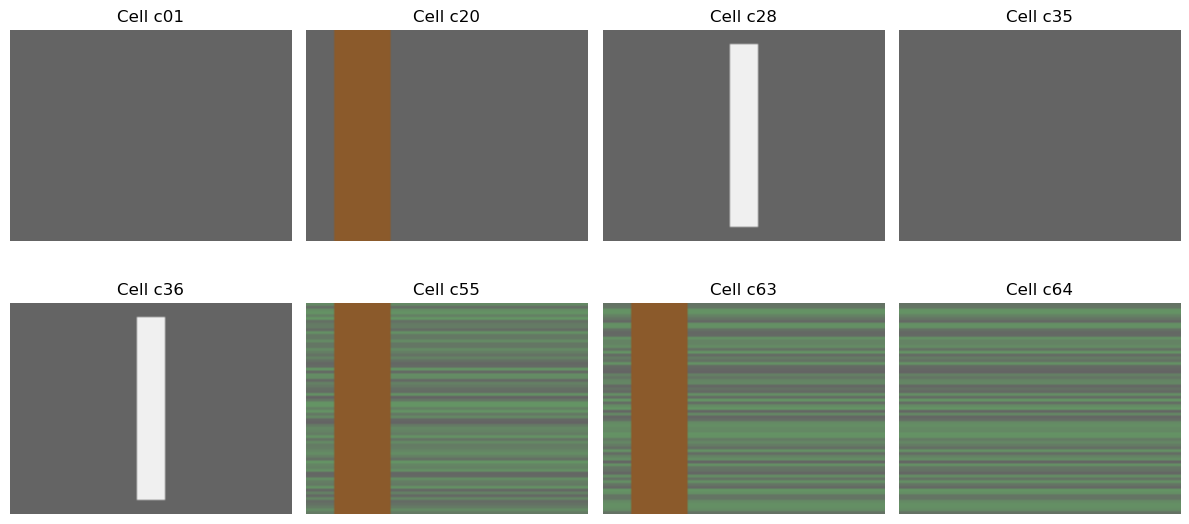

In [5]:
# Split image into grid cells
cells = split_image_to_grid(synthetic_img)
print(f"Split image into {len(cells)} cells")
print(f"Each cell shape: {cells[0].shape}")

# Visualize some cells
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
cells_to_show = [0, 19, 27, 34, 35, 54, 62, 63]  # Various cells

for ax, cell_idx in zip(axes.flat, cells_to_show):
    ax.imshow(cells[cell_idx])
    ax.set_title(f'Cell c{cell_idx+1:02d}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [19]:
# Extract features from cells
print("Extracting features from all 64 cells...")
all_features = extract_grid_features(synthetic_img)

print(f"\nFeatures extracted:")
print(f"  Number of cells: {len(all_features)}")
print(f"  Features per cell: {len(all_features[0])}")

# Show feature vector structure
feature = all_features[34]  # Cell 35 (ball)
print(f"\nFeature breakdown (example from cell 35):")
print(f"  Total features: {len(feature)}")
print(f"  Feature min: {feature.min():.4f}")
print(f"  Feature max: {feature.max():.4f}")
print(f"  Feature mean: {feature.mean():.4f}")

# Show features for cell 35 only
np.set_printoptions(precision=4, suppress=True, linewidth=200)
print(f"\nCell c35 features ({feature.size}):")
print(feature)


Extracting features from all 64 cells...

Features extracted:
  Number of cells: 64
  Features per cell: 1053

Feature breakdown (example from cell 35):
  Total features: 1053
  Feature min: -0.0000
  Feature max: 1.0000
  Feature mean: 0.0098

Cell c35 features (1053):
[ 0.      0.      0.     ...  1.      0.1538 -0.    ]

Features extracted:
  Number of cells: 64
  Features per cell: 1053

Feature breakdown (example from cell 35):
  Total features: 1053
  Feature min: -0.0000
  Feature max: 1.0000
  Feature mean: 0.0098

Cell c35 features (1053):
[ 0.      0.      0.     ...  1.      0.1538 -0.    ]


## 4. Annotation

Create annotations for training data.

In [20]:
# Create annotation for our synthetic image
# Based on the objects we placed:
# - Ball in cell 35
# - Bat in cells 20, 55, 63
# - Stumps in cells 28, 36

cell_labels = {
    35: 1,  # Ball
    20: 2,  # Bat
    55: 2,  # Bat
    63: 2,  # Bat
    28: 3,  # Stump
    36: 3,  # Stump
}

annotation = create_annotation('synthetic_test.jpg', cell_labels)

print("Annotation created:")
print(f"  Image: {annotation['image_filename']}")
print(f"  Labels: {annotation['labels']}")

# Summarize
for cls, name in CLASS_LABELS.items():
    count = annotation['labels'].count(cls)
    print(f"  {name}: {count} cells")

Annotation created:
  Image: synthetic_test.jpg
  Labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0]
  no_object: 58 cells
  ball: 1 cells
  bat: 3 cells
  stump: 2 cells


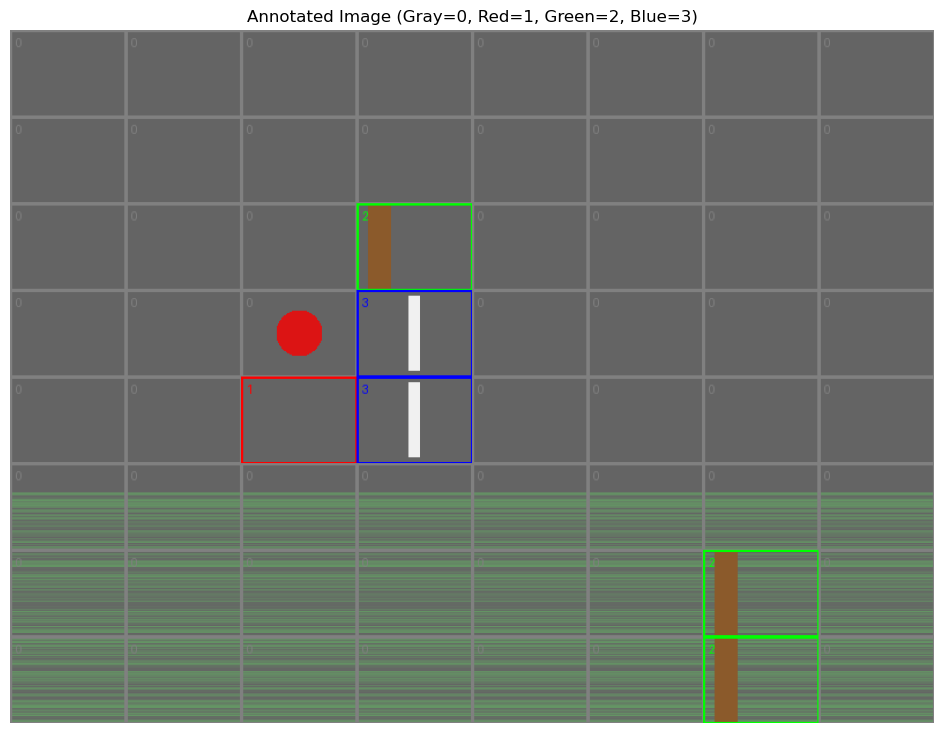

In [8]:
# Visualize annotation on image
annotated_img = visualize_annotation(synthetic_img, annotation['labels'])

plt.figure(figsize=(12, 9))
plt.imshow(annotated_img)
plt.title('Annotated Image (Gray=0, Red=1, Green=2, Blue=3)')
plt.axis('off')
plt.show()

## 5. Training

Train the model using extracted features.

Creating 10 synthetic training images...
Created 10 training images


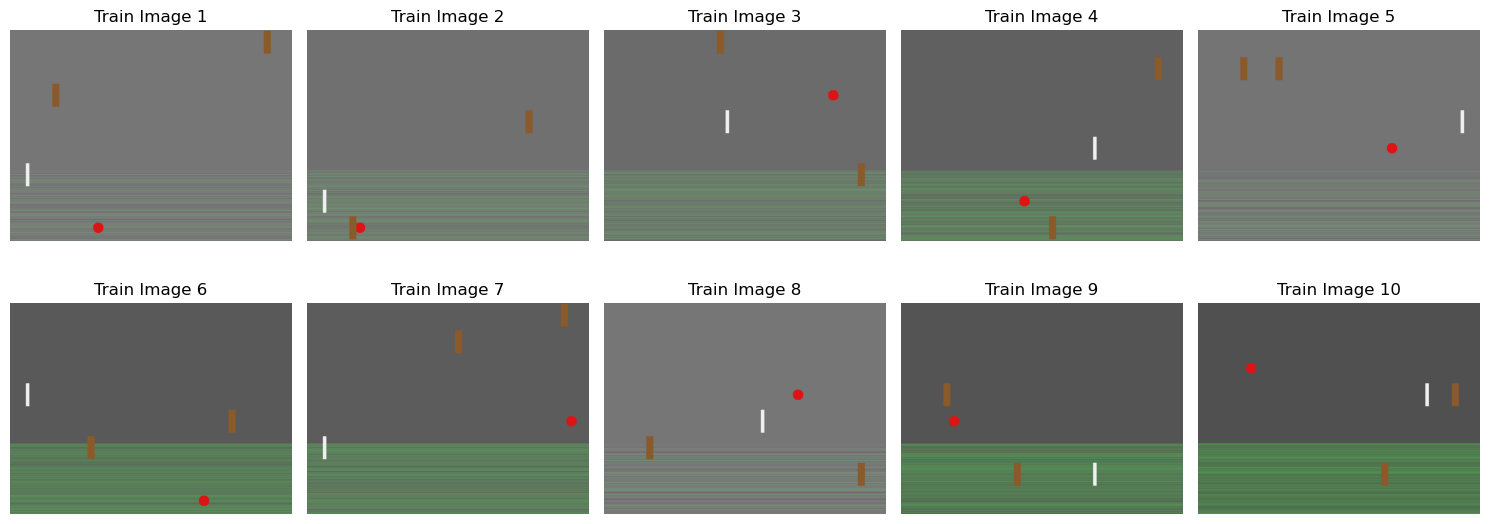

In [8]:
# Prepare training data (using synthetic images)
# In practice, you would load real images and annotations

# Create multiple synthetic images with different object positions
np.random.seed(42)
n_train_images = 10

train_images = []
train_labels = []

print(f"Creating {n_train_images} synthetic training images...")

for i in range(n_train_images):
    # Create base image
    img = np.ones((600, 800, 3), dtype=np.uint8) * (80 + np.random.randint(40))
    
    # Add grass texture
    for y in range(400, 600):
        img[y, :, 1] = 100 + np.random.randint(0, 50)
    
    # Random labels
    labels = [0] * 64
    
    # Add random ball
    ball_cell = np.random.randint(1, 65)
    labels[ball_cell-1] = 1
    x1, y1, x2, y2 = get_grid_cell_bounds(ball_cell)
    cy, cx = (y1+y2)//2, (x1+x2)//2
    for y in range(max(0,cy-15), min(600,cy+15)):
        for x in range(max(0,cx-15), min(800,cx+15)):
            if (y-cy)**2 + (x-cx)**2 < 15**2:
                img[y, x] = [220, 20, 20]
    
    # Add random bat cells
    bat_cells = np.random.choice(range(1, 65), size=2, replace=False)
    for cell_idx in bat_cells:
        labels[cell_idx-1] = 2
        x1, y1, x2, y2 = get_grid_cell_bounds(cell_idx)
        img[y1+5:y2-5, x1+20:x1+40] = [139, 90, 43]
    
    # Add random stump
    stump_cell = np.random.randint(1, 65)
    labels[stump_cell-1] = 3
    x1, y1, x2, y2 = get_grid_cell_bounds(stump_cell)
    img[y1+5:y2-5, x1+45:x1+55] = [240, 240, 240]
    
    train_images.append(img)
    train_labels.append(labels)

print(f"Created {len(train_images)} training images")

# Visualize synthetic training images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for ax, img, idx in zip(axes.flat, train_images, range(len(train_images))):
    ax.imshow(img)
    ax.set_title(f'Train Image {idx+1}')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [9]:
# Prepare features for training
X, y = prepare_training_data(train_images, train_labels)

print(f"Training data prepared:")
print(f"  Feature matrix shape: {X.shape}")
print(f"  Label vector shape: {y.shape}")

Extracting features from training images...
Processing image 10/10...
Processing image 10/10...
Feature matrix shape: (640, 1053)
Label vector shape: (640,)
Class distribution: {np.int64(0): np.int64(601), np.int64(1): np.int64(9), np.int64(2): np.int64(20), np.int64(3): np.int64(10)}
Training data prepared:
  Feature matrix shape: (640, 1053)
  Label vector shape: (640,)
Feature matrix shape: (640, 1053)
Label vector shape: (640,)
Class distribution: {np.int64(0): np.int64(601), np.int64(1): np.int64(9), np.int64(2): np.int64(20), np.int64(3): np.int64(10)}
Training data prepared:
  Feature matrix shape: (640, 1053)
  Label vector shape: (640,)


In [11]:
print(f"  Sample features (first row): {X[0][:10]} ...")

  Sample features (first row): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] ...


In [12]:
# Train the model
print("Training Random Forest classifier...")
model, mean, std = train_model(X, y, model_type='random_forest')

# Save the model
os.makedirs('models', exist_ok=True)
model_path = save_trained_model(model, mean, std, 'PravinTeam', 'models')
print(f"\nModel saved to: {model_path}")

Training Random Forest classifier...

Training random_forest classifier...
Training Random Forest with 20 trees...
  Trained 5/20 trees
  Trained 10/20 trees
  Trained 15/20 trees
  Trained 10/20 trees
  Trained 15/20 trees
  Trained 20/20 trees
Training accuracy: 1.0000
Model saved to models\model_PravinTeam.pkl

Model saved to: models\model_PravinTeam.pkl
  Trained 20/20 trees
Training accuracy: 1.0000
Model saved to models\model_PravinTeam.pkl

Model saved to: models\model_PravinTeam.pkl


## 6. Prediction

Make predictions on new images.

In [14]:
# Make prediction on the original synthetic image
# First, simulate loading from file by extracting features directly

cell_features = extract_grid_features(synthetic_img)
X_test = np.array(cell_features)
X_test_scaled = (X_test - mean) / std

predictions = model.predict(X_test_scaled)

print("Predictions for synthetic test image:")
print(f"\nGrid of predictions (8x8):")
for row in range(8):
    row_preds = predictions[row*8:(row+1)*8]
    print(f"Row {row+1}: {' '.join(str(int(p)) for p in row_preds)}")

# Count objects
print(f"\nObject counts:")
for cls, name in CLASS_LABELS.items():
    count = np.sum(predictions == cls)
    print(f"  {name}: {count}")

Predictions for synthetic test image:

Grid of predictions (8x8):
Row 1: 0 0 0 0 0 0 0 0
Row 2: 0 0 0 0 0 0 0 0
Row 3: 0 0 0 2 0 0 0 0
Row 4: 0 0 1 3 0 0 0 0
Row 5: 0 0 0 3 0 0 0 0
Row 6: 0 0 0 0 0 0 0 0
Row 7: 0 0 0 0 0 0 2 0
Row 8: 0 0 0 0 0 0 2 0

Object counts:
  no_object: 58
  ball: 1
  bat: 3
  stump: 2


## 7. CSV Output Generation

In [15]:
# Generate CSV output
header = create_csv_header()
print("CSV Header:")
print(header)

# Create a row for our prediction
row = create_csv_row('synthetic_test.jpg', 'Test', predictions.tolist())
print("\nCSV Row:")
print(row)

CSV Header:
ImageFileName,TrainOrTest,c01,c02,c03,c04,c05,c06,c07,c08,c09,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19,c20,c21,c22,c23,c24,c25,c26,c27,c28,c29,c30,c31,c32,c33,c34,c35,c36,c37,c38,c39,c40,c41,c42,c43,c44,c45,c46,c47,c48,c49,c50,c51,c52,c53,c54,c55,c56,c57,c58,c59,c60,c61,c62,c63,c64

CSV Row:
synthetic_test.jpg,Test,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,3,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0


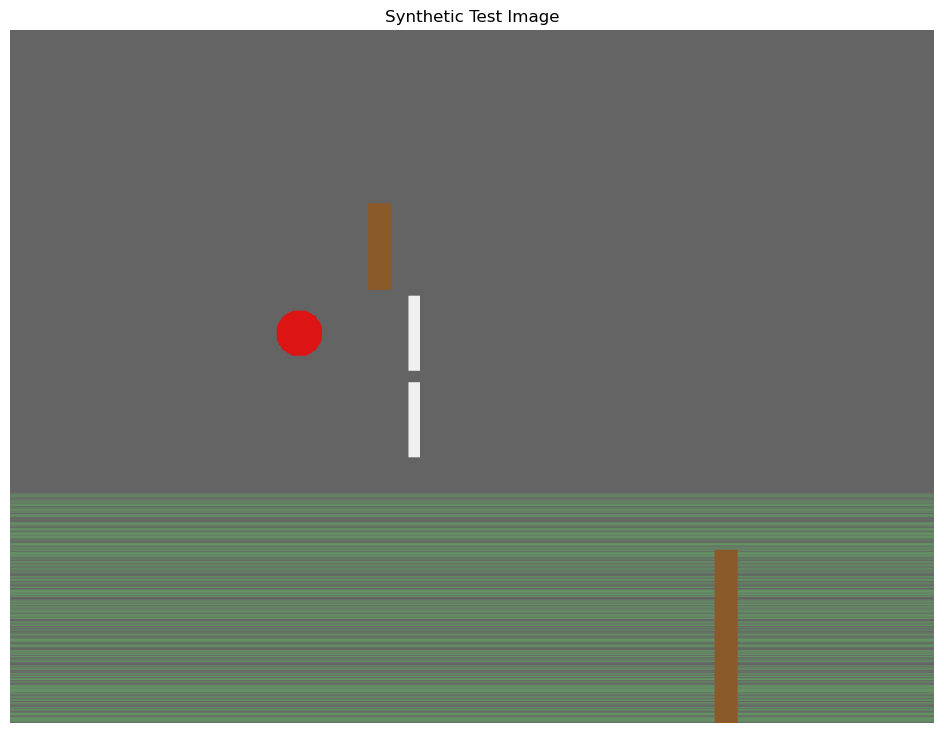

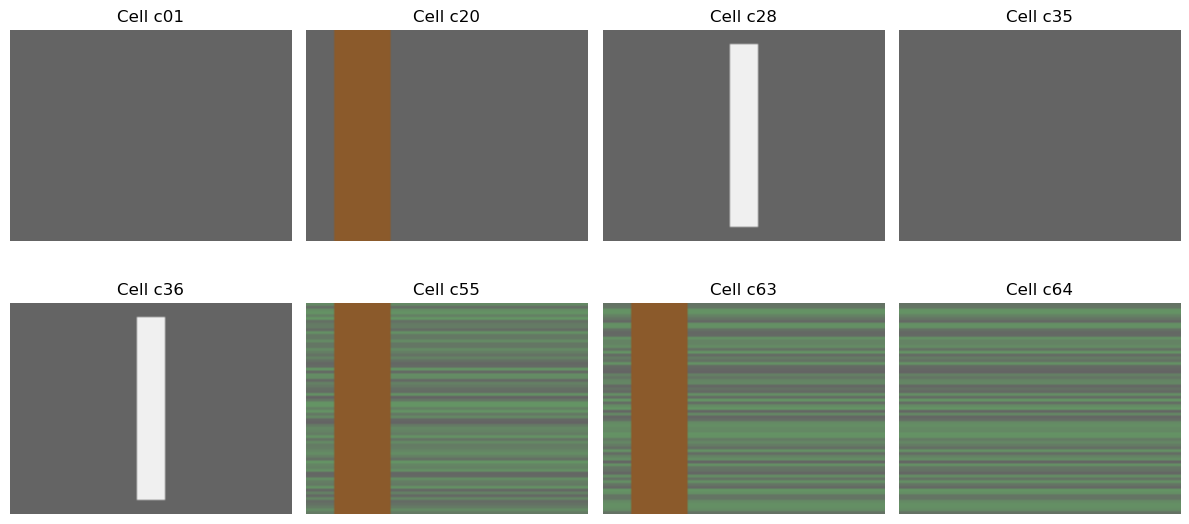

In [16]:
# Display the synthetic test image and a few sample grid cells

plt.figure(figsize=(12, 9))
plt.imshow(synthetic_img)
plt.title('Synthetic Test Image')
plt.axis('off')
plt.show()

fig, axes2 = plt.subplots(2, 4, figsize=(12, 6))
for ax2, ci in zip(axes2.flat, cells_to_show):
    ax2.imshow(cells[ci])
    ax2.set_title(f'Cell c{ci+1:02d}')
    ax2.axis('off')
plt.tight_layout()
plt.show()

In [17]:
# Write to CSV file
os.makedirs('outputs', exist_ok=True)
output_path = 'outputs/predictions.csv'

with open(output_path, 'w') as f:
    f.write(header + '\n')
    f.write(row + '\n')

print(f"CSV output written to: {output_path}")

# Display file contents
print("\nFile contents:")
with open(output_path, 'r') as f:
    print(f.read())

CSV output written to: outputs/predictions.csv

File contents:
ImageFileName,TrainOrTest,c01,c02,c03,c04,c05,c06,c07,c08,c09,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19,c20,c21,c22,c23,c24,c25,c26,c27,c28,c29,c30,c31,c32,c33,c34,c35,c36,c37,c38,c39,c40,c41,c42,c43,c44,c45,c46,c47,c48,c49,c50,c51,c52,c53,c54,c55,c56,c57,c58,c59,c60,c61,c62,c63,c64
synthetic_test.jpg,Test,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,3,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0



## Summary

This notebook demonstrated the complete pipeline:

1. **Grid System**: 800x600 images divided into 8x8 grid (64 cells of 100x75 pixels)

2. **Feature Extraction**: Hand-crafted features including:
   - Color histograms (RGB and HSV)
   - HOG (Histogram of Oriented Gradients)
   - Edge features
   - Shape features (Hu moments)
   - Color moments
   - Texture features

3. **Model Training**: Random Forest or Logistic Regression classifiers

4. **Prediction**: Per-cell classification (0=no_object, 1=ball, 2=bat, 3=stump)

5. **CSV Output**: Format: ImageFileName, TrainOrTest, c01, c02, ..., c64

### Next Steps for Real Implementation:
1. Collect 300+ cricket images
2. Preprocess images to 800x600
3. Create annotations for each image
4. Train the model
5. Evaluate on test set
6. Generate final CSV output

## Training Model with Your Actual Cricket Data
This section loads images from `data/Balls`, `data/Bats`, and `data/Stumps`, preprocesses them, extracts features, and trains a Random Forest classifier.

In [18]:
import glob
from PIL import Image
import numpy as np
import os

# Helper to load and preprocess up to 20 images per folder
def load_and_preprocess_images(folder, label, img_size=(800,600), max_images=20):
    images = []
    labels = []
    img_paths = glob.glob(os.path.join(folder, '*'))[:max_images]
    for img_path in img_paths:
        try:
            img = Image.open(img_path).convert('RGB')
            img = img.resize(img_size)
            img_np = np.array(img)
            images.append(img_np)
            labels.append([label]*64)  # Each cell gets the same label for now
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
    return images, labels

balls_imgs, balls_labels = load_and_preprocess_images('data/Balls', 1, max_images=5)
bats_imgs, bats_labels = load_and_preprocess_images('data/Bats', 2, max_images=5)
stumps_imgs, stumps_labels = load_and_preprocess_images('data/Stumps', 3, max_images=5)

all_images = balls_imgs + bats_imgs + stumps_imgs
all_labels = balls_labels + bats_labels + stumps_labels
print(f"Loaded {len(all_images)} images.")

Loaded 15 images.


In [23]:
import threading

def process_image(img, cell_labels, features_list, labels_list, idx):
    cells = split_image_to_grid(img)
    features = [extract_cell_features(cell) for cell in cells]
    features_list[idx] = features
    labels_list[idx] = cell_labels

num_threads = min(5, len(all_images))
threads = []
features_list = [None] * len(all_images)
labels_list = [None] * len(all_images)

for i in range(len(all_images)):
    t = threading.Thread(target=process_image, args=(all_images[i], all_labels[i], features_list, labels_list, i))
    threads.append(t)

# Start threads in batches of num_threads
for batch_start in range(0, len(threads), num_threads):
    batch = threads[batch_start:batch_start+num_threads]
    for t in batch:
        t.start()
    for t in batch:
        t.join()

all_features = []
all_labels_flat = []
for features, cell_labels in zip(features_list, labels_list):
    all_features.extend(features)
    all_labels_flat.extend(cell_labels)

X = np.array(all_features)
y = np.array(all_labels_flat)
print(f"Feature matrix shape: {X.shape}")
print(f"Label vector shape: {y.shape}")

Feature matrix shape: (960, 1053)
Label vector shape: (960,)


In [25]:
# Train Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Ball', 'Bat', 'Stump']))

              precision    recall  f1-score   support

        Ball       0.73      0.97      0.83        59
         Bat       0.96      0.78      0.86        69
       Stump       0.93      0.84      0.89        64

    accuracy                           0.86       192
   macro avg       0.88      0.86      0.86       192
weighted avg       0.88      0.86      0.86       192



In [26]:
# Save the trained model
import joblib
os.makedirs('models', exist_ok=True)
joblib.dump(clf, 'models/model_cricket_rf.pkl')
print('Model saved to models/model_cricket_rf.pkl')

Model saved to models/model_cricket_rf.pkl


In [29]:
# Test the trained model on 20 random images from each class
import random
from PIL import Image
import numpy as np
import joblib
import glob
import os
from sklearn.metrics import classification_report
model_path = 'models/model_cricket_rf.pkl'
clf = joblib.load(model_path)
def get_random_images(folder, n=20, img_size=(800,600)):
    img_paths = glob.glob(os.path.join(folder, '*'))
    selected = random.sample(img_paths, min(n, len(img_paths)))
    images = []
    for img_path in selected:
        try:
            img = Image.open(img_path).convert('RGB')
            img = img.resize(img_size)
            images.append(np.array(img))
        except Exception as e:
            print(f'Error loading {img_path}: {e}')
    return images
balls_test = get_random_images('data/Balls', 2)
bats_test = get_random_images('data/Bats', 2)
stumps_test = get_random_images('data/Stumps', 2)
test_images = balls_test + bats_test + stumps_test
test_labels = ([1]*len(balls_test)) + ([2]*len(bats_test)) + ([3]*len(stumps_test))

# Extract features for all test images
test_features = []
for img in test_images:
    cells = split_image_to_grid(img)
    cell_features = [extract_cell_features(cell) for cell in cells]
    test_features.extend(cell_features)
test_labels_flat = []
for label in test_labels:
    test_labels_flat.extend([label]*64)
X_test = np.array(test_features)
y_test = np.array(test_labels_flat)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Ball', 'Bat', 'Stump']))

c:\Users\pravi\PG IITB\cricket_object_detection\src\features.py:36: RuntimeWarning: invalid value encountered in divide
  s = np.where(max_val != 0, diff / max_val, 0)


              precision    recall  f1-score   support

        Ball       0.76      0.72      0.74       128
         Bat       0.59      0.77      0.67       128
       Stump       0.77      0.56      0.65       128

    accuracy                           0.68       384
   macro avg       0.70      0.68      0.68       384
weighted avg       0.70      0.68      0.68       384



In [30]:
# Save test predictions to CSV
import pandas as pd
os.makedirs('outputs', exist_ok=True)
csv_header = ['ImageFileName', 'Class', 'c01', 'c02', 'c03', 'c04', 'c05', 'c06', 'c07', 'c08', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19', 'c20', 'c21', 'c22', 'c23', 'c24', 'c25', 'c26', 'c27', 'c28', 'c29', 'c30', 'c31', 'c32', 'c33', 'c34', 'c35', 'c36', 'c37', 'c38', 'c39', 'c40', 'c41', 'c42', 'c43', 'c44', 'c45', 'c46', 'c47', 'c48', 'c49', 'c50', 'c51', 'c52', 'c53', 'c54', 'c55', 'c56', 'c57', 'c58', 'c59', 'c60', 'c61', 'c62', 'c63', 'c64']
rows = []
for idx, img in enumerate(test_images):
    img_name = f'test_img_{idx+1}.jpg'
    label = test_labels[idx]
    pred_cells = y_pred[idx*64:(idx+1)*64]
    row = [img_name, label] + pred_cells.tolist()
    rows.append(row)
df = pd.DataFrame(rows, columns=csv_header)
output_csv_path = 'outputs/test_predictions.csv'
df.to_csv(output_csv_path, index=False)
print(f'Test predictions saved to {output_csv_path}')

Test predictions saved to outputs/test_predictions.csv


In [33]:
# Annotate each test image with predicted cell labels and highlight cells matching image label, then save annotated images



os.makedirs('outputs/annotated', exist_ok=True)
for idx, img in enumerate(test_images):
    pred_cells = y_pred[idx*64:(idx+1)*64]
    img_label = test_labels[idx]
    # Highlight cells where prediction == image label
    highlight_mask = [1 if p == img_label else 0 for p in pred_cells]
    # Custom visualize_annotation: overlay highlight (yellow border) for matching cells
    annotated_img = visualize_annotation(img, pred_cells, highlight_mask=highlight_mask)
    out_path = f'outputs/annotated/test_img_{idx+1}_annotated.png'
    Image.fromarray(annotated_img).save(out_path)
    print(f'Annotated image saved: {out_path}')


TypeError: visualize_annotation() got an unexpected keyword argument 'highlight_mask'